In [ ]:
!pip install torch torchvision matplotlib


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:


# Paths
base_path = "/content/drive/MyDrive/Dataset"
images_path = os.path.join(base_path, "train")   # images
masks_path = os.path.join(base_path, "masks")   # masks


In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, size=(512, 512)):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.images = sorted(os.listdir(image_dir))
        self.transform = transform
        self.size = size

        # Build mapping base_name → mask_path
        self.mask_dict = {}
        for m in os.listdir(mask_dir):
            base = os.path.splitext(m)[0]
            self.mask_dict[base] = os.path.join(mask_dir, m)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_base = os.path.splitext(img_name)[0]

        img_path = os.path.join(self.image_dir, img_name)
        if img_base not in self.mask_dict:
            raise FileNotFoundError(f"No mask found for {img_name} (base={img_base})")
        mask_path = self.mask_dict[img_base]

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        # resize both image and mask
        image = image.resize(self.size, Image.BILINEAR)
        mask = mask.resize(self.size, Image.NEAREST)  # NEAREST to keep class labels

        if self.transform:
            image = self.transform(image)
        else:
            image = T.ToTensor()(image)

        mask = np.array(mask, dtype=np.int64)
        mask = torch.from_numpy(mask).long()
        return image, mask


In [ ]:
transform = T.Compose([
    T.Resize((512, 512)),
    T.ToTensor()
])

train_dataset = SegmentationDataset(images_path, masks_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

# Debug: show first image + mask pair
img, mask = train_dataset[0]
print("Image shape:", img.shape)
print("Mask shape:", mask.shape)


Image shape: torch.Size([3, 512, 512])
Mask shape: torch.Size([512, 512])


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True)

# Adjust classifier for your number of classes
num_classes = 6   # (background + 5 classes, change if needed)
model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


100%|██████████| 233M/233M [00:01<00:00, 186MB/s]


In [ ]:
epochs = 15
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        outputs = model(images)['out']
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}")

torch.save(model.state_dict(), "deeplabv3_resnet101.pth")


Epoch [1/15], Loss: 1.4688
Epoch [2/15], Loss: 1.0714
Epoch [3/15], Loss: 0.8824
Epoch [4/15], Loss: 0.7740
Epoch [5/15], Loss: 0.7043
Epoch [6/15], Loss: 0.6391
Epoch [7/15], Loss: 0.5948
Epoch [8/15], Loss: 0.4617
Epoch [9/15], Loss: 0.4911
Epoch [10/15], Loss: 0.4779
Epoch [11/15], Loss: 0.3479
Epoch [12/15], Loss: 0.3228
Epoch [13/15], Loss: 0.3377
Epoch [14/15], Loss: 0.2889
Epoch [15/15], Loss: 0.3296


In [ ]:
class_names = ["Land", "Buildings", "Road", "Feilds", "Car", "Lake"]  # adjust as per your dataset

# Define color map for visualization
import numpy as np
colors = np.array([
    (0, 0, 0),        # Background
    (128, 0, 0),      # Building
    (0, 128, 0),      # Road
    (128, 128, 0),    # Tree
    (0, 0, 128),      # Car
    (128, 0, 128)     # Water
])


In [ ]:
def decode_segmap(mask, colors=colors):
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    for l in range(len(colors)):
        idx = mask == l
        r[idx] = colors[l, 0]
        g[idx] = colors[l, 1]
        b[idx] = colors[l, 2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb


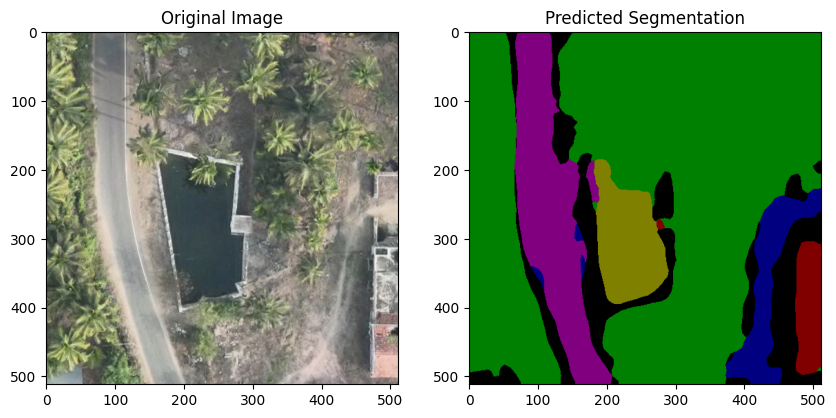

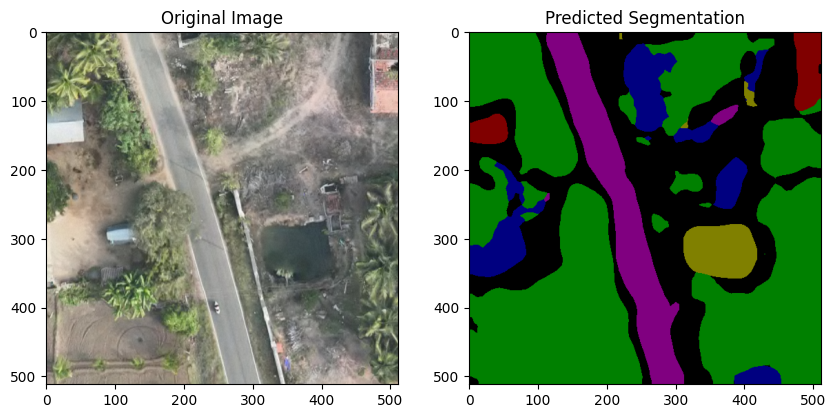

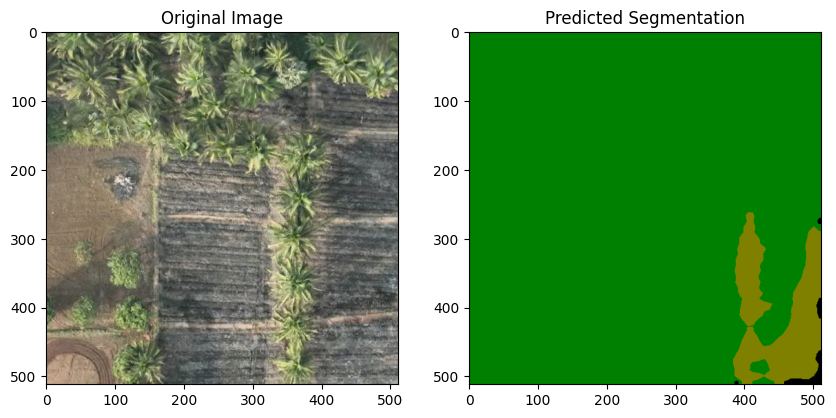

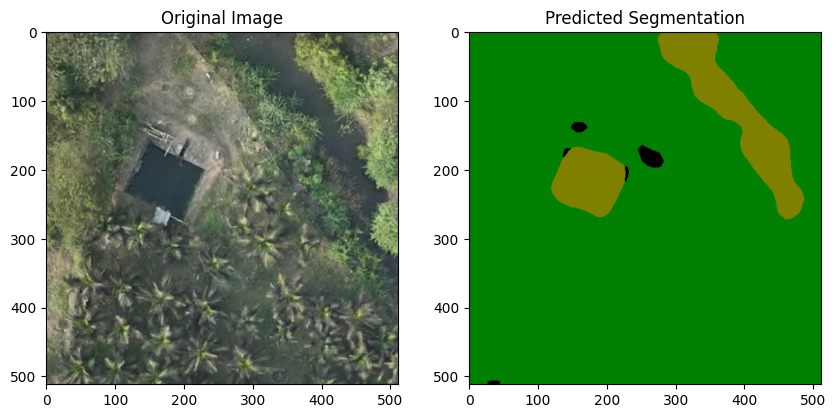

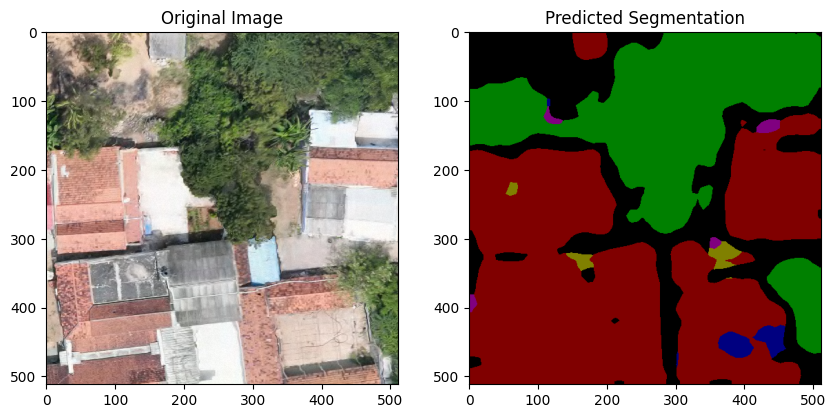

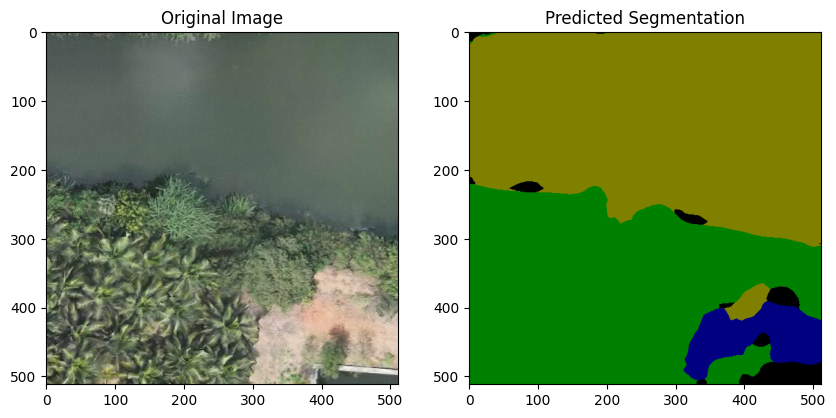

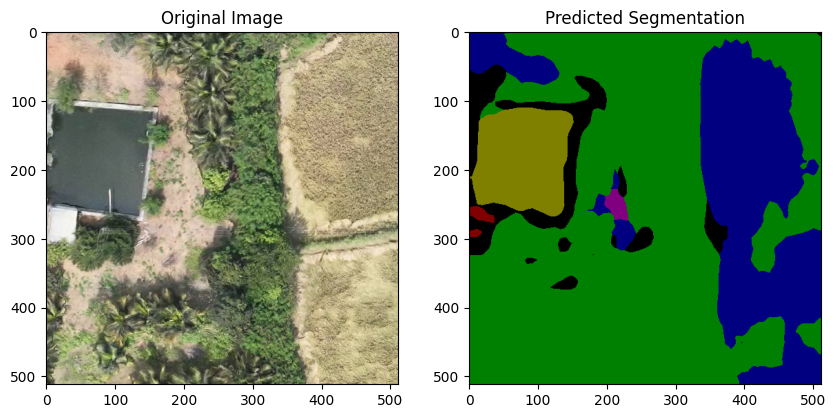

In [ ]:
import os
from PIL import Image
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt

# Path to test images
test_images_path = "/content/drive/MyDrive/Dataset/Test"   # folder with only images

# Image preprocessing (same as training)
transform = T.Compose([
    T.Resize((512, 512)),
    T.ToTensor()
])

# Put model in eval mode
model.eval()

# Loop through test images
with torch.no_grad():
    for img_name in os.listdir(test_images_path):
        img_path = os.path.join(test_images_path, img_name)
        image = Image.open(img_path).convert("RGB")

        input_tensor = transform(image).unsqueeze(0).to(device)  # [1,C,H,W]

        # Forward pass
        output = model(input_tensor)["out"]
        pred = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

        # Decode prediction into RGB colors
        pred_rgb = decode_segmap(pred)

        # Show results
        plt.figure(figsize=(10,5))
        plt.subplot(1,2,1)
        plt.imshow(image)
        plt.title("Original Image")

        plt.subplot(1,2,2)
        plt.imshow(pred_rgb)
        plt.title("Predicted Segmentation")

        plt.show()


In [ ]:
import pickle

# Save full model as pickle
pkl_path = "/content/drive/MyDrive/Dataset/deeplabv3_model.pkl"
with open(pkl_path, 'wb') as f:
    pickle.dump(model, f)

print(f"Model saved as Pickle at {pkl_path}")


Model saved as Pickle at /content/drive/MyDrive/Dataset/deeplabv3_model.pkl


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch

# 🔹 Define your custom classes
CLASS_NAMES = [
    "background",   # 0
    "road",         # 1
    "building",     # 2
    "Lake",         # 3
    "Land",         # 4
    "Fields"        # 5
]

# 🔹 Fixed color map
COLORS = np.array([
    [0, 0, 0],        # background
    [0, 255, 0],      # road
    [0, 0, 255],      # building
    [0, 255, 255],    # lake
    [255, 0, 0],      # land
    [255, 0, 255]     # fields
], dtype=np.uint8)

# 🔹 Decode segmentation mask into RGB
def decode_segmap(mask):
    r = np.zeros_like(mask, dtype=np.uint8)
    g = np.zeros_like(mask, dtype=np.uint8)
    b = np.zeros_like(mask, dtype=np.uint8)
    for l in range(len(CLASS_NAMES)):
        idx = mask == l
        r[idx], g[idx], b[idx] = COLORS[l]
    return np.stack([r, g, b], axis=2)

# 🔹 Overlay class labels with background rectangle
def overlay_labels_on_prediction(image, pred_mask, class_names, scale_factor=2):
    # Upscale image first
    h, w = image.shape[:2]
    overlay = cv2.resize((image * 255).astype(np.uint8), (w*scale_factor, h*scale_factor), interpolation=cv2.INTER_NEAREST)

    unique_classes = np.unique(pred_mask)
    pred_mask_up = cv2.resize(pred_mask.astype(np.uint8), (w*scale_factor, h*scale_factor), interpolation=cv2.INTER_NEAREST)

    for cls_id in unique_classes:
        if cls_id == 0 or cls_id >= len(class_names):
            continue

        mask = (pred_mask_up == cls_id).astype(np.uint8)
        color = COLORS[cls_id]
        overlay[mask == 1] = (
            0.6 * overlay[mask == 1] + 0.4 * color
        ).astype(np.uint8)

        # Add label on largest blob
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            cnt = max(contours, key=cv2.contourArea)
            if cv2.contourArea(cnt) > 500:
                x, y, w_box, h_box = cv2.boundingRect(cnt)
                label = class_names[cls_id]

                # Scale font based on segment size
                font_scale = max(0.5, min(w_box, h_box)/100)
                thickness = int(max(1, font_scale*2))
                (text_w, text_h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)

                # Draw filled rectangle behind text
                cv2.rectangle(
                    overlay,
                    (x, max(y - text_h - 5, 0)),
                    (x + text_w, y),
                    (0, 0, 0),
                    -1
                )

                # Draw text
                cv2.putText(
                    overlay, label,
                    (x, max(y - 5, 0)),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    font_scale,
                    (255, 255, 255),
                    thickness,
                    cv2.LINE_AA
                )

    return overlay

# 🔹 Fix road/building swap in predictions
def fix_road_building(pred_mask):
    pred_fixed = pred_mask.copy()
    temp = pred_fixed == 1
    pred_fixed[pred_fixed == 2] = 1
    pred_fixed[temp] = 2
    return pred_fixed

# 🔹 Visualization loop (first 3 images)
model.eval()
shown = 0
with torch.no_grad():
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)["out"]
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        masks = masks.cpu().numpy()

        preds = np.array([fix_road_building(p) for p in preds])

        for i in range(images.size(0)):
            if shown >= 3:
                break

            img = images[i].permute(1, 2, 0).cpu().numpy()
            img = np.clip(img, 0, 1)

            pred_rgb = decode_segmap(preds[i])
            mask_rgb = decode_segmap(masks[i])
            overlay_img = overlay_labels_on_prediction(img, preds[i], CLASS_NAMES, scale_factor=2)

            plt.figure(figsize=(30, 10))
            plt.subplot(1, 4, 1)
            plt.imshow(cv2.resize((img*255).astype(np.uint8), (img.shape[1]*2, img.shape[0]*2), interpolation=cv2.INTER_NEAREST))
            plt.title("Original", fontsize=16)

            plt.subplot(1, 4, 2)
            plt.imshow(cv2.resize(mask_rgb, (mask_rgb.shape[1]*2, mask_rgb.shape[0]*2), interpolation=cv2.INTER_NEAREST))
            plt.title("Ground Truth", fontsize=16)

            plt.subplot(1, 4, 3)
            plt.imshow(cv2.resize(pred_rgb, (pred_rgb.shape[1]*2, pred_rgb.shape[0]*2), interpolation=cv2.INTER_NEAREST))
            plt.title("Predicted", fontsize=16)

            plt.subplot(1, 4, 4)
            plt.imshow(overlay_img)
            plt.title("Predicted + Labels", fontsize=16)

            plt.show()
            shown += 1

        if shown >= 3:
            break


In [ ]:
model_save_path

'/content/drive/MyDrive/Dataset/deeplabv3_model.pth'

In [ ]:
weights_path = "/content/drive/MyDrive/Dataset/deeplabv3_weights.pth"
torch.save(model.state_dict(), weights_path)

print(f"Weights saved at {weights_path}")


Weights saved at /content/drive/MyDrive/Dataset/deeplabv3_weights.pth
